## Setting

1. ドライブをマウントする
2. csv保存用のout_pathのmodel_nameを設定する（既存モデルの結果を上書きしないように）
3. 動作確認した場合はエポック数、fold数を戻す
4. 全セルを実行

In [1]:
!pip install kaggle

In [2]:
# copy kaggle.json
!cp /content/drive/MyDrive/kaggle/Google_Brain/kaggle.json /content/

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c 'ventilator-pressure-prediction'

 99% 138M/139M [00:00<00:00, 120MB/s] 
100% 139M/139M [00:00<00:00, 159MB/s]
 77% 58.0M/75.4M [00:00<00:00, 79.0MB/s]
100% 75.4M/75.4M [00:00<00:00, 128MB/s] 
  0% 0.00/8.50M [00:00<?, ?B/s]
100% 8.50M/8.50M [00:00<00:00, 139MB/s]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time, logging, gc, os
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math

from sklearn.model_selection import KFold, GroupKFold

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.models import Model, load_model

# COMPUTE_LSTM_IMPORTANCE = True
COMPUTE_LSTM_IMPORTANCE = False

In [4]:
# train = pd.read_csv('/content/train.csv.zip')
# test = pd.read_csv('/content/test.csv.zip')

train = pd.read_csv('/content/drive/MyDrive/kaggle/Google_Brain/data/nearly_row/train_add_rolling.csv.zip')
test = pd.read_csv('/content/drive/MyDrive/kaggle/Google_Brain/data/nearly_row/test_add_rolling.csv.zip')

train

,id,breath_id,R,C,time_step,u_in,u_out,pressure,15_in_sum,15_in_min,15_in_max,15_in_mean,45_in_sum,45_in_min,45_in_max,45_in_mean
0,1,1,20,50,0.000000,0.083334,0,5.837492,0.083334,0.083334,0.083334,0.083334,0.083334,0.083334,0.083334,0.083334
1,2,1,20,50,0.033652,18.383041,0,5.907794,18.466375,0.083334,18.383041,9.233188,18.466375,0.083334,18.383041,9.233188
2,3,1,20,50,0.067514,22.509278,0,7.876254,40.975653,0.083334,22.509278,13.658551,40.975653,0.083334,22.509278,13.658551
3,4,1,20,50,0.101542,22.808822,0,11.742872,63.784476,0.083334,22.808822,15.946119,63.784476,0.083334,22.808822,15.946119
4,5,1,20,50,0.135756,25.355850,0,12.234987,89.140326,0.083334,25.355850,17.828065,89.140326,0.083334,25.355850,17.828065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032,19.228896,1.113529,1.489714,1.281926,140.943536,0.000000,14.017899,3.132079
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032,19.603865,1.137701,1.489714,1.306924,142.432033,0.000000,14.017899,3.165156
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729,19.995327,1.137701,1.558978,1.333022,130.090426,0.000000,14.017899,2.890898
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938,20.115881,1.137701,1.558978,1.341059,117.345191,0.000000,12.616385,2.607671


In [5]:
test

,id,breath_id,R,C,time_step,u_in,u_out,15_in_sum,15_in_min,15_in_max,15_in_mean,45_in_sum,45_in_min,45_in_max,45_in_mean
0,1,0,5,20,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,2,0,5,20,0.031904,7.515046,0,7.515046,0.000000,7.515046,3.757523,7.515046,0.0,7.515046,3.757523
2,3,0,5,20,0.063827,14.651675,0,22.166721,0.000000,14.651675,7.388907,22.166721,0.0,14.651675,7.388907
3,4,0,5,20,0.095751,21.230610,0,43.397331,0.000000,21.230610,10.849333,43.397331,0.0,21.230610,10.849333
4,5,0,5,20,0.127644,26.320956,0,69.718287,0.000000,26.320956,13.943657,69.718287,0.0,26.320956,13.943657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023995,4023996,125748,20,10,2.530117,4.971245,1,73.183249,4.693262,4.971245,4.878883,125.753821,0.0,4.971245,2.794529
4023996,4023997,125748,20,10,2.563853,4.975709,1,73.465696,4.741088,4.975709,4.897713,130.729530,0.0,4.975709,2.905101
4023997,4023998,125748,20,10,2.597475,4.979468,1,73.704075,4.781253,4.979468,4.913605,135.708997,0.0,4.979468,3.015755
4023998,4023999,125748,20,10,2.631134,4.982648,1,73.905470,4.815235,4.982648,4.927031,140.691645,0.0,4.982648,3.126481


In [6]:
def add_features(df):
    # #真崎追加 u_outが1になってからの時間とu_outを掛け算（排気量の積分値）
    df = pd.merge(df, df[df["u_out"]==0].groupby("breath_id").max()["time_step"].reset_index(), on="breath_id", suffixes=['', '_2'])
    df['cross3']= (df["time_step"]-df["time_step_2"])*df['u_out']

    df['cross']= df['u_in'] * df['u_out']
    df['cross2']= df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['time_step_cumsum'] = df.groupby(['breath_id'])['time_step'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    print("Step-1...Completed")
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)

    # df['u_in_lag'] = df['u_in'].shift(1).fillna(0)
    # df['u_in_lag'] = df['u_in_lag']*df['breath_id_lagsame']
    # df['u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    # df['u_in_lag2'] = df['u_in_lag2']*df['breath_id_lag2same']
    # df['u_out_lag2'] = df['u_out'].shift(2).fillna(0)
    # df['u_out_lag2'] = df['u_out_lag2']*df['breath_id_lag2same']
    # #df['u_in_lag'] = df['u_in'].shift(2).fillna(0)

    print("Step-2...Completed")
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_in__mean'] = df.groupby(['breath_id'])['u_in'].transform('mean')
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    print("Step-3...Completed")
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    print("Step-4...Completed")
    
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['breath_id__u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['breath_id__u_in_lag'] = df['breath_id__u_in_lag'] * df['breath_id_lagsame']
    df['breath_id__u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['breath_id__u_in_lag2'] = df['breath_id__u_in_lag2'] * df['breath_id_lag2same']
    print("Step-5...Completed")
    
    df['time_step_diff'] = df.groupby('breath_id')['time_step'].diff().fillna(0)
    # df['ewm_u_in_mean'] = (df\
    #                        .groupby('breath_id')['u_in']
    #                        .ewm(halflife=9)\
    #                        .mean()\
    #                        .reset_index(level=0,drop=True))
    print("Step-6...Completed")
    
    df['u_in_lagback_diff1'] = df['u_in'] - df['u_in_lag_back1']
    df['u_out_lagback_diff1'] = df['u_out'] - df['u_out_lag_back1']
    df['u_in_lagback_diff2'] = df['u_in'] - df['u_in_lag_back2']
    df['u_out_lagback_diff2'] = df['u_out'] - df['u_out_lag_back2']

    print("Step-7...Completed")
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    print("Step-8...Completed")
    
    return df

train = add_features(train)
test = add_features(test)

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-7...Completed
Step-8...Completed
Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-7...Completed
Step-8...Completed


In [7]:
drop_col =  ['u_in_lag_back3',
 'cross',
 'u_out_lag_back3',
 '45_in_max',
 'time_step_cumsum',
 '45_in_mean',
 '15_in_sum',
 '15_in_min',
 'area',
 'u_in_cumsum',
 'u_in_cummean',
 '15_in_max',
 'u_in_lag_back4',
 '45_in_sum',
 '45_in_min']

y = train['pressure'].to_numpy().reshape(-1, 80)
# train.drop(["cross2", "time_step", "time_step_2", 'pressure','id', 'breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2'], axis=1, inplace=True)
train.drop(['pressure','id', 'breath_id','one','count',
            'breath_id_lag','breath_id_lag2','breath_id_lagsame',
            'breath_id_lag2same',
            'time_step_2'
            ] + drop_col,
            axis=1, inplace=True)

# test = test.drop(["cross2", "time_step", "time_step_2", 'id', 'breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2'], axis=1)
test = test.drop(['id', 'breath_id','one','count','breath_id_lag',
                  'breath_id_lag2','breath_id_lagsame',
                  'breath_id_lag2same',
                  'time_step_2'
                  ] + drop_col,
                 axis=1)

train

,time_step,u_in,u_out,15_in_mean,cross3,cross2,u_in_lag1,u_out_lag1,u_in_lag_back1,u_out_lag_back1,u_in_lag2,u_out_lag2,u_in_lag_back2,u_out_lag_back2,u_in_lag3,u_out_lag3,u_in_lag4,u_out_lag4,u_out_lag_back4,breath_id__u_in__max,breath_id__u_in__mean,breath_id__u_in__diffmax,breath_id__u_in__diffmean,u_in_diff1,u_out_diff1,u_in_diff2,u_out_diff2,u_in_diff3,u_out_diff3,u_in_diff4,u_out_diff4,breath_id__u_in_lag,breath_id__u_in_lag2,time_step_diff,u_in_lagback_diff1,u_out_lagback_diff1,u_in_lagback_diff2,u_out_lagback_diff2,R_20,R_5,R_50,C_10,C_20,C_50,R__C_20__10,R__C_20__20,R__C_20__50,R__C_50__10,R__C_50__20,R__C_50__50,R__C_5__10,R__C_5__20,R__C_5__50
0,0.000000,0.083334,0,0.083334,-0.000000,0.000000,0.000000,0.0,18.383041,0.0,0.000000,0.0,22.509278,0.0,0.000000,0.0,0.000000,0.0,0.0,28.313036,10.146007,28.229702,10.062673,0.083334,0.0,0.083334,0.0,0.083334,0.0,0.083334,0.0,0.000000,0.000000,0.000000,-18.299707,0.0,-22.425944,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1,0.033652,18.383041,0,9.233188,-0.000000,0.000000,0.083334,0.0,22.509278,0.0,0.000000,0.0,22.808822,0.0,0.000000,0.0,0.000000,0.0,0.0,28.313036,10.146007,9.929994,-8.237035,18.299707,0.0,18.383041,0.0,18.383041,0.0,18.383041,0.0,0.083334,0.000000,0.033652,-4.126236,0.0,-4.425781,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
2,0.067514,22.509278,0,13.658551,-0.000000,0.000000,18.383041,0.0,22.808822,0.0,0.083334,0.0,25.355850,0.0,0.000000,0.0,0.000000,0.0,0.0,28.313036,10.146007,5.803758,-12.363271,4.126236,0.0,22.425944,0.0,22.509278,0.0,22.509278,0.0,18.383041,0.083334,0.033862,-0.299544,0.0,-2.846573,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
3,0.101542,22.808822,0,15.946119,-0.000000,0.000000,22.509278,0.0,25.355850,0.0,18.383041,0.0,27.259866,0.0,0.083334,0.0,0.000000,0.0,0.0,28.313036,10.146007,5.504214,-12.662816,0.299544,0.0,4.425781,0.0,22.725488,0.0,22.808822,0.0,22.509278,18.383041,0.034028,-2.547028,0.0,-4.451044,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,0.135756,25.355850,0,17.828065,-0.000000,0.000000,22.808822,0.0,27.259866,0.0,22.509278,0.0,27.127486,0.0,18.383041,0.0,0.083334,0.0,0.0,28.313036,10.146007,2.957185,-15.209844,2.547028,0.0,2.846573,0.0,6.972809,0.0,25.272516,0.0,22.808822,22.509278,0.034213,-1.904016,0.0,-1.771635,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035995,2.504603,1.489714,1,1.281926,1.536860,2.504603,1.420711,1.0,1.488497,1.0,1.353205,1.0,1.558978,1.0,1.357586,1.0,1.362261,1.0,1.0,25.504196,4.911402,24.014482,3.421689,0.069002,0.0,0.136509,0.0,0.132127,0.0,0.127452,0.0,1.420711,1.353205,0.033412,0.001217,0.0,-0.069264,0.0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0
6035996,2.537961,1.488497,1,1.306924,1.570218,2.537961,1.489714,1.0,1.558978,1.0,1.420711,1.0,1.272663,1.0,1.353205,1.0,1.357586,1.0,0.0,25.504196,4.911402,24.015699,3.422905,-0.001217,0.0,0.067785,0.0,0.135292,0.0,0.130910,0.0,1.489714,1.420711,0.033358,-0.070481,0.0,0.215834,0.0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0
6035997,2.571408,1.558978,1,1.333022,1.603665,2.571408,1.488497,1.0,1.272663,1.0,1.489714,1.0,1.482739,1.0,1.420711,1.0,1.353205,1.0,0.0,25.504196,4.911402,23.945218,3.352424,0.070481,0.0,0.069264,0.0,0.138266,0.0,0.205773,0.0,1.488497,1.489714,0.033447,0.286315,0.0,0.076239,0.0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0
6035998,2.604744,1.272663,1,1.341059,1.637002,2.604744,1.558978,1.0,1.482739,1.0,1.488497,1.0,0.000000,0.0,1.489714,1.0,1.420711,1.0,0.0,25.504196,4.911402,24.231532,3.638739,-0.286315,0.0,-0.215834,0.0,-0.217050,0.0,-0.148048,0.0,1.558978,1.488497,0.033337,-0.210076,0.0,1.272663,1.0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0


In [8]:
COLS = list(train.columns)

In [9]:
rb = RobustScaler()

rb.fit(train)
train = rb.transform(train)
test = rb.transform(test)

train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])
gc.collect()

102

In [10]:
# Detect hardware, return appropriate distribution strategy
print(tf.version.VERSION)
tf.get_logger().setLevel(logging.ERROR)
try: # detect TPU
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPU(s) and enable mixed precision
    strategy = tf.distribute.MirroredStrategy() # works on GPU and multi-GPU
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.config.optimizer.set_jit(True) # XLA compilation
    tf.keras.mixed_precision.experimental.set_policy(policy)
    print('Mixed precision enabled')
print("REPLICAS: ", strategy.num_replicas_in_sync)

2.6.0


REPLICAS:  8


In [11]:
def plot_hist(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model performance")
    plt.ylabel("mean_absolute_error")
    plt.xlabel("epoch")
    plt.ylim(0, 0.4)
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [12]:
def create_model():   
    with strategy.scope():
    
        model = Sequential([
            Input(shape=(80, test.shape[2])),

            Bidirectional(LSTM(768, return_sequences=True)),
            Bidirectional(LSTM(512, return_sequences=True)),
            Bidirectional(LSTM(256, return_sequences=True)),            
            Bidirectional(LSTM(128, return_sequences=True)),
            Bidirectional(GRU(64, return_sequences=True)),
            Dense(128, activation='selu'),
            Dense(1)
        ])

        model.compile(optimizer="adam",loss = "mae")
        # huber_loss = tf.keras.losses.Huber(delta=0.5, reduction="auto", name="huber_loss")
        # model.compile(optimizer="adam", loss = huber_loss)
    return(model)

In [13]:
# def create_model():
    
#     x_input = Input(shape=(train.shape[-2:]))
    
#     x1 = Bidirectional(LSTM(units=768, return_sequences=True))(x_input)
#     x2 = Bidirectional(LSTM(units=512, return_sequences=True))(x1)
#     x3 = Bidirectional(LSTM(units=256, return_sequences=True))(x2)
#     x4 = Bidirectional(LSTM(units=128, return_sequences=True))(x3)
    
#     z2 = Bidirectional(GRU(units=256, return_sequences=True))(x2)
#     z3 = Bidirectional(GRU(units=128, return_sequences=True))(Add()([x3, z2]))
#     z4 = Bidirectional(GRU(units=64, return_sequences=True))(Add()([x4, z3]))

#     x = Concatenate(axis=2)([x4, z2, z3, z4])
    
#     x = Dense(units=128, activation='selu')(x)
    
#     x_output = Dense(units=1)(x)

#     model = Model(inputs=x_input, outputs=x_output, 
#                   name='DNN_Model')
#     model.compile(optimizer="adam",loss = "mae")

#     return model

In [14]:
def getNewestModel(model, dirname):
    from glob import glob
    target = os.path.join(dirname, '*')
    files = [(f, os.path.getmtime(f)) for f in glob(target)]
    if len(files) == 0:
        return model
    else:
        newestModel = sorted(files, key=lambda files: files[1])[-1]
        model.load_weights(newestModel[0])
        return model

In [15]:
model_name = "TPU2"
CP_Path = "CheckPoint"

out_path = f"/content/drive/MyDrive/kaggle/Google_Brain/LSTM/{model_name}/"
BaseCPDir = f"/content/drive/MyDrive/kaggle/Google_Brain/LSTM/{model_name}/{CP_Path}/"

!mkdir "/content/drive/MyDrive/kaggle/Google_Brain/LSTM/{model_name}/"
!rm -r "/content/drive/MyDrive/kaggle/Google_Brain/LSTM/{model_name}/{CP_Path}/"
!mkdir "/content/drive/MyDrive/kaggle/Google_Brain/LSTM/{model_name}/{CP_Path}/"

mkdir: cannot create directory ‘/content/drive/MyDrive/kaggle/Google_Brain/LSTM/TPU2/’: File exists


In [15]:
## PCAで次元削減して2つにした特徴量から求めた角度θを特徴量に加える

# Calculate tanθ from 2 features made by PCA
def make_radian_row(pca_result):
    rad = []
    for r in pca_result:
        rad.append(math.atan(r[0]/r[1]))

    return rad

def apply_PCA(df):
    # standard scaling
    scaler = StandardScaler()
    scaler.fit(df)
    df_standard = scaler.transform(df)

    # PCA
    pca = PCA(n_components=2)
    pca.fit(df_standard)

    # Tanθ
    df["rad"] = make_radian_row(pca.transform(df_standard))

    return df

****** fold: 1 *******
Epoch 1/300
118/118 [==============================] - 104s 606ms/step - loss: 2.2049 - val_loss: 0.8908

Epoch 00001: val_loss improved from inf to 0.89082, saving model to /content/drive/MyDrive/kaggle/Google_Brain/LSTM/TPU2/CheckPoint/LSTM_.01-0.89.hdf5
Epoch 2/300
118/118 [==============================] - 43s 363ms/step - loss: 0.7592 - val_loss: 0.6045

Epoch 00002: val_loss improved from 0.89082 to 0.60454, saving model to /content/drive/MyDrive/kaggle/Google_Brain/LSTM/TPU2/CheckPoint/LSTM_.02-0.60.hdf5
Epoch 3/300
118/118 [==============================] - 43s 363ms/step - loss: 0.5785 - val_loss: 0.5508

Epoch 00003: val_loss improved from 0.60454 to 0.55077, saving model to /content/drive/MyDrive/kaggle/Google_Brain/LSTM/TPU2/CheckPoint/LSTM_.03-0.55.hdf5
Epoch 4/300
118/118 [==============================] - 43s 363ms/step - loss: 0.5128 - val_loss: 0.4502

Epoch 00004: val_loss improved from 0.55077 to 0.45024, saving model to /content/drive/MyDrive/

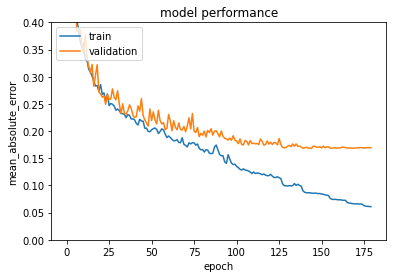

****** fold: 2 *******
Epoch 1/300
118/118 [==============================] - 102s 605ms/step - loss: 1.9624 - val_loss: 0.9434

Epoch 00001: val_loss improved from inf to 0.94340, saving model to /content/drive/MyDrive/kaggle/Google_Brain/LSTM/TPU2/CheckPoint/LSTM_.01-0.94.hdf5
Epoch 2/300
118/118 [==============================] - 43s 367ms/step - loss: 0.7168 - val_loss: 0.5736

Epoch 00002: val_loss improved from 0.94340 to 0.57361, saving model to /content/drive/MyDrive/kaggle/Google_Brain/LSTM/TPU2/CheckPoint/LSTM_.02-0.57.hdf5
Epoch 3/300
118/118 [==============================] - 43s 364ms/step - loss: 0.5559 - val_loss: 0.5464

Epoch 00003: val_loss improved from 0.57361 to 0.54641, saving model to /content/drive/MyDrive/kaggle/Google_Brain/LSTM/TPU2/CheckPoint/LSTM_.03-0.55.hdf5
Epoch 4/300
118/118 [==============================] - 43s 362ms/step - loss: 0.4917 - val_loss: 0.4385

Epoch 00004: val_loss improved from 0.54641 to 0.43854, saving model to /content/drive/MyDrive/

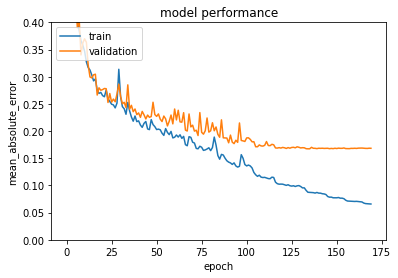

****** fold: 3 *******
Epoch 1/300
118/118 [==============================] - 104s 611ms/step - loss: 1.9687 - val_loss: 0.8297

Epoch 00001: val_loss improved from inf to 0.82968, saving model to /content/drive/MyDrive/kaggle/Google_Brain/LSTM/TPU2/CheckPoint/LSTM_.01-0.83.hdf5
Epoch 2/300
118/118 [==============================] - 43s 367ms/step - loss: 0.7338 - val_loss: 0.6112

Epoch 00002: val_loss improved from 0.82968 to 0.61117, saving model to /content/drive/MyDrive/kaggle/Google_Brain/LSTM/TPU2/CheckPoint/LSTM_.02-0.61.hdf5
Epoch 3/300
118/118 [==============================] - 43s 363ms/step - loss: 0.5738 - val_loss: 0.5080

Epoch 00003: val_loss improved from 0.61117 to 0.50796, saving model to /content/drive/MyDrive/kaggle/Google_Brain/LSTM/TPU2/CheckPoint/LSTM_.03-0.51.hdf5
Epoch 4/300
118/118 [==============================] - 43s 363ms/step - loss: 0.4854 - val_loss: 0.5120

Epoch 00004: val_loss did not improve from 0.50796
Epoch 5/300
118/118 [=======================

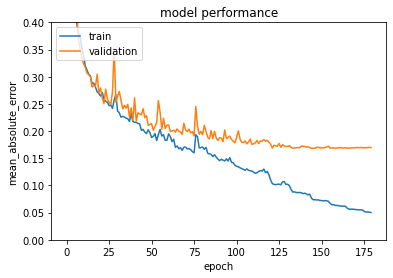

****** fold: 4 *******
Epoch 1/300
118/118 [==============================] - 113s 627ms/step - loss: 2.0019 - val_loss: 0.8657

Epoch 00001: val_loss improved from inf to 0.86570, saving model to /content/drive/MyDrive/kaggle/Google_Brain/LSTM/TPU2/CheckPoint/LSTM_.01-0.87.hdf5
Epoch 2/300
118/118 [==============================] - 44s 373ms/step - loss: 0.7461 - val_loss: 0.5581

Epoch 00002: val_loss improved from 0.86570 to 0.55815, saving model to /content/drive/MyDrive/kaggle/Google_Brain/LSTM/TPU2/CheckPoint/LSTM_.02-0.56.hdf5
Epoch 3/300
118/118 [==============================] - 43s 367ms/step - loss: 0.5706 - val_loss: 0.4917

Epoch 00003: val_loss improved from 0.55815 to 0.49171, saving model to /content/drive/MyDrive/kaggle/Google_Brain/LSTM/TPU2/CheckPoint/LSTM_.03-0.49.hdf5
Epoch 4/300
118/118 [==============================] - 43s 367ms/step - loss: 0.4994 - val_loss: 0.5165

Epoch 00004: val_loss did not improve from 0.49171
Epoch 5/300
118/118 [=======================

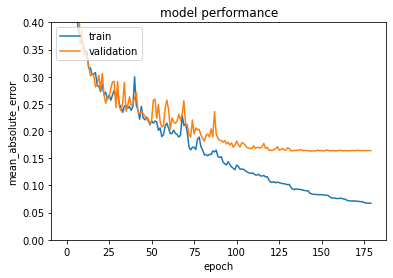

****** fold: 5 *******
Epoch 1/300
118/118 [==============================] - 105s 614ms/step - loss: 2.0623 - val_loss: 0.8559

Epoch 00001: val_loss improved from inf to 0.85586, saving model to /content/drive/MyDrive/kaggle/Google_Brain/LSTM/TPU2/CheckPoint/LSTM_.01-0.86.hdf5
Epoch 2/300
118/118 [==============================] - 43s 367ms/step - loss: 0.7378 - val_loss: 0.5895

Epoch 00002: val_loss improved from 0.85586 to 0.58951, saving model to /content/drive/MyDrive/kaggle/Google_Brain/LSTM/TPU2/CheckPoint/LSTM_.02-0.59.hdf5
Epoch 3/300
118/118 [==============================] - 43s 363ms/step - loss: 0.5576 - val_loss: 0.5143

Epoch 00003: val_loss improved from 0.58951 to 0.51430, saving model to /content/drive/MyDrive/kaggle/Google_Brain/LSTM/TPU2/CheckPoint/LSTM_.03-0.51.hdf5
Epoch 4/300
118/118 [==============================] - 43s 363ms/step - loss: 0.5138 - val_loss: 0.6106

Epoch 00004: val_loss did not improve from 0.51430
Epoch 5/300
118/118 [=======================

In [ ]:
N_SPLIT = 5
EPOCKS = 300
BATCH_SIZE = 512

mean_folds_score = 0
test_preds = []
folds_score = []
kf = KFold(n_splits=N_SPLIT, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(train, y)):
    print(f"****** fold: {fold+1} *******")
    X_train, X_valid = train[train_idx], train[test_idx]
    y_train, y_valid = y[train_idx], y[test_idx]
    
    # Add tanθ feature using PCA
    X_train = apply_PCA(X_train)
    X_valid = apply_PCA(X_valid)
    y_train = apply_PCA(y_train)
    y_valid = apply_PCA(y_valid)

    # params1:base lr  params2:update epock number  params3:update params1*params3 per params2 epoch
    # scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, 200*((len(train)*0.8)/BATCH_SIZE), 1e-5)
    scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.75, patience=10, verbose=1)
    es = EarlyStopping(monitor='val_loss',mode='min', patience=35, verbose=1,restore_best_weights=True)

    # save good model check point
    chkpt = os.path.join(BaseCPDir, 'LSTM_.{epoch:02d}-{val_loss:.2f}.hdf5')
    cp = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    
    model = create_model()
        
    history = model.fit(
        X_train, y_train, 
        validation_data=(X_valid, y_valid), 
        epochs= EPOCKS, 
        batch_size = BATCH_SIZE, 
        callbacks = [
                     #  tf.keras.callbacks.LearningRateScheduler(scheduler), 
                     scheduler,
                     es,
                     cp]
        )
    
    # Extract most great val score model
    model = getNewestModel(model, BaseCPDir)
    
    # save&display valid score
    score = model.evaluate(X_valid, y_valid, verbose=1)
    folds_score.append(score)
    mean_folds_score += score
    print(f"fold{fold+1} val score: {round(score, 4)}")

    # Predict test pressure
    test_preds.append(model.predict(test).squeeze().reshape(-1, 1).squeeze())
    plot_hist(history)

    
    # Plot Feature Importance
    if COMPUTE_LSTM_IMPORTANCE:
        results = []
        print(' Computing LSTM feature importance...')
        
        # COMPUTE BASELINE (NO SHUFFLE)
        oof_preds = model.predict(X_valid, verbose=0).squeeze() 
        baseline_mae = np.mean(np.abs( oof_preds-y_valid ))
        results.append({'feature':'BASELINE','mae':baseline_mae})  

        for k in tqdm(range(len(COLS))):
                    
            # SHUFFLE FEATURE K
            save_col = X_valid[:,:,k].copy()
            np.random.shuffle(X_valid[:,:,k])
                    
            # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
            oof_preds = model.predict(X_valid, verbose=0).squeeze() 
            mae = np.mean(np.abs( oof_preds-y_valid ))
            results.append({'feature':COLS[k],'mae':mae})
            X_valid[:,:,k] = save_col

        # DISPLAY LSTM FEATURE IMPORTANCE
        print()
        df = pd.DataFrame(results)
        df = df.sort_values('mae')
        plt.figure(figsize=(10,20))
        plt.barh(np.arange(len(COLS)+1),df.mae)
        plt.yticks(np.arange(len(COLS)+1),df.feature.values)
        plt.title('LSTM Feature Importance',size=16)
        plt.ylim((-1,len(COLS)+1))
        plt.plot([baseline_mae,baseline_mae],[-1,len(COLS)+1], '--', color='orange',
                  label=f'Baseline OOF\nMAE={baseline_mae:.3f}')
        plt.xlabel(f'Fold {fold+1} OOF MAE with feature permuted',size=14)
        plt.ylabel('Feature',size=14)
        plt.legend()
        plt.show()
                            
        # SAVE LSTM FEATURE IMPORTANCE
        df = df.sort_values('mae',ascending=False)
        df.to_csv(out_path + f'lstm_feature_importance_fold_{fold+1}.csv',index=False)


    del X_train, X_valid, y_train, y_valid, model
    gc.collect()

print("EACH FOLD SCORE:", folds_score)
print(f"MEAN VAL SCORE: {round(mean_folds_score/N_SPLIT, 4)}")

In [ ]:
## get 950 unique pressure
train = pd.read_csv('/content/train.csv.zip')
pressure_unique = np.array(sorted(train['pressure'].unique()))

In [ ]:
# GET MEAN THE PRESSURE
submission = pd.read_csv('/content/sample_submission.csv.zip')
submission["pressure"] = sum(test_preds)/5  #test_preds[1]
# ROUND PREDICTIONS (Post Preprocessing)
submission['pressure'] = submission['pressure'].map(lambda x: pressure_unique[np.abs(pressure_unique-x).argmin()])

submission.to_csv(out_path + "submission_mean.csv", index=False)
submission   

In [ ]:
# GET MEDIAN THE PRESSURE
submission["pressure"] = np.median(np.vstack(test_preds),axis=0)
# ROUND PREDICTIONS (Post Preprocessing)
submission['pressure'] = submission['pressure'].map(lambda x: pressure_unique[np.abs(pressure_unique-x).argmin()])

submission.to_csv(out_path + "submission_median.csv", index=False)
submission

In [ ]:
# ENSEMBLE FOLDS WITH MEDIAN
submission_mean = pd.read_csv(out_path + "submission_mean.csv")
submission_median = pd.read_csv(out_path + "submission_median.csv")

submission["pressure"] = submission_mean["pressure"] * 0.5 + submission_median["pressure"] * 0.5
submission.to_csv(out_path + "submission.csv", index=False)
submission

In [ ]:
# これを実行するとkaggleにsubmitされるため注意（submitは1日5回まで）
!kaggle competitions submit ventilator-pressure-prediction -f "/content/drive/MyDrive/kaggle/Google_Brain/LSTM/{model_name}/submission.csv" -m "LSTM_TPU"